# Customer Churn Prediction Analysis
This notebook presents a predictive analytics solution to identify high-risk churn customers in a telecommunications company. 
The main objective is to develop a machine learning model that helps the company:
- Proactively Identify: Detect customers with high probability of churning before it happens
- Understand Key Factors: Determine the most influential variables in customer churn
- Optimize Retention: Provide actionable insights for personalized retention strategies
## Business Context
- Dataset of 5,000 customers with 20 different variables
- Variables include demographic data, usage patterns, and service metrics
- Target variable: "churn" (customer abandonment)
- Data imbalance: 14.14% of customers have churned
## Methodological Approach
- Exploratory Analysis: Deep understanding of variables and their relationships
- Feature Engineering: Creation of new variables to capture behavioral patterns
- Modeling: Implementation of Random Forest Classifier with class imbalance considerations
- Evaluation: Focus on business-relevant metrics (precision, recall, ROC-AUC)




In [11]:
# Data manipulation
import pandas as pd
import numpy as np
# Data visualization
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
# Data preprocessing
from sklearn.preprocessing import LabelEncoder
# Statistics
from scipy.stats import stats
# Model selection
from sklearn.model_selection import train_test_split
# Model
from sklearn.ensemble import RandomForestClassifier
# metrics.
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, confusion_matrix,roc_curve, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import optuna
#warnings
import warnings
warnings.filterwarnings('ignore')


First of all, we will load the dataset, in this case a CSV file, and then we'll take a first look to understand the nature of our variables and try to give them meaning oriented to our business problem: predicting customer churn, which is our target variable.

In [12]:
# load data
data = pd.read_csv('churn_all.csv')

# First look at the data - 10 first rows
data.head(10)


,state,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,Churn
0,KS,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
5,AL,510,391-8027,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False
6,MA,510,355-9993,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False
7,MO,415,329-9001,yes,no,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False
8,LA,408,335-4719,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
9,WV,415,330-8173,yes,yes,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False


In [13]:
# shape of the dataset
data.shape

(5000, 20)

We observe that this is a dataset with 5000 records and 20 columns, in this case, 19 predictor variables and 1 target variable.
On the other hand, the dataset is not computationally heavy, so we will be able to efficiently adjust the hyperparameters of possible models locally.

Since for this test we don't have more detailed information regarding the variables, we will define based on the column name, the meaning of each variable. It's important to note that if we had the possibility to contact business when necessary, we could obtain more relevant information for this problem.

1. Customer Variables:
- `state`: State where the customer resides
- `area_code`: Telephone area code
- `phone_number`: Customer's phone number
- `international_plan`: Whether they have an international plan (yes/no)
- `voice_mail_plan`: Whether they have a voicemail plan (yes/no)

2. Service Usage Variables:
- `number_vmail_messages`: Number of voicemail messages
- `total_day_minutes`: Total minutes in calls during the day
- `total_day_calls`: Total number of calls during the day
- `total_day_charge`: Total charge for daytime calls
- `total_eve_minutes`: Total minutes in calls during the evening
- `total_eve_calls`: Total number of calls during the evening
- `total_eve_charge`: Total charge for evening calls
- `total_night_minutes`: Total minutes in night calls
- `total_night_calls`: Total number of night calls
- `total_night_charge`: Total charge for night calls
- `total_intl_minutes`: Total minutes in international calls
- `total_intl_calls`: Total number of international calls
- `total_intl_charge`: Total charge for international calls
- `number_customer_service_calls`: Number of calls to customer service

3. Target Variable:
- `churn`: Indicates whether the customer left the service (True/False)

At first glance, common patterns between variables stand out: we observe how they are classified according to the time slot: day, eve and night. Data that we will take into account later for feature engineering.

## EDA and data cleaning

In [14]:
# columns info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          5000 non-null   object 
 1   area_code                      5000 non-null   int64  
 2   phone_number                   5000 non-null   object 
 3   international_plan             5000 non-null   object 
 4   voice_mail_plan                5000 non-null   object 
 5   number_vmail_messages          5000 non-null   int64  
 6   total_day_minutes              5000 non-null   float64
 7   total_day_calls                5000 non-null   int64  
 8   total_day_charge               5000 non-null   float64
 9   total_eve_minutes              5000 non-null   float64
 10  total_eve_calls                5000 non-null   int64  
 11  total_eve_charge               5000 non-null   float64
 12  total_night_minutes            5000 non-null   f

In [15]:
# transoform phone number as category
data['phone_number'] = data['phone_number'].astype('category')

In [16]:
# duplicated values
data.duplicated().sum()

0

First of all, we observe that there are no duplicate values or missing values in the dataset, therefore, it will not be necessary to perform null data treatment. On the other hand, we can see that the variable types are boolean, categorical and numerical, so next, we will separate the columns according to their type and perform an initial descriptive analysis.

In [17]:
# categorical columns
cat_cols= data.select_dtypes(include=['object','category']).columns
# numeric columns
num_cols= data.select_dtypes(include=['int64','float64']).columns
# boolean columns
bool_cols= data.select_dtypes(include=['bool']).columns

- target variable

In [18]:
data[bool_cols].describe()

,Churn
count,5000
unique,2
top,False
freq,4293


In [19]:
# target variable distribution
print('Percentage of clients that have left the service: \n',
       data.Churn.value_counts()/data.shape[0]*100)

Percentage of clients that have left the service: 
 Churn
False    85.86
True     14.14
Name: count, dtype: float64


We observe a clear imbalance in the target variable. With 85.86% of customers who have left the service, while 14.14% of customers have not left the service. We will need to take this imbalance into account when training the model, for this we will use the stratified split method when dividing the dataset into train and test.

- categorical columns

In [20]:
# Resumen estadístico de las columnas categóricas.
data[cat_cols].describe()

,state,phone_number,international_plan,voice_mail_plan
count,5000,5000,5000,5000
unique,51,5000,2,2
top,WV,327-1058,no,no
freq,158,1,4527,3677


- numeric columns

In [21]:
# numeric columns summary
data[num_cols].describe()

,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,436.911400,7.755200,180.288900,119.834000,30.649668,200.636560,100.191000,17.054322,200.391620,99.919200,9.017732,10.261780,4.435200,2.771196,1.570400
std,42.209182,13.546393,53.894699,442.739543,9.162069,50.551309,19.826496,4.296843,50.527789,19.958686,2.273763,2.761396,2.456788,0.745514,1.306363
min,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,408.000000,0.000000,143.700000,87.000000,24.430000,166.375000,87.000000,14.140000,166.900000,87.000000,7.510000,8.500000,3.000000,2.300000,1.000000
50%,415.000000,0.000000,180.100000,100.000000,30.620000,201.000000,100.000000,17.090000,200.400000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000
75%,415.000000,17.000000,216.200000,113.000000,36.750000,234.100000,114.000000,19.900000,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000
max,510.000000,52.000000,351.500000,9999.000000,59.760000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


The main statistics we focus on are the measures of centrality, mean and median, as with these values we can get an idea of what the possible distribution bias would be. All numerical columns, except for 'number_vmail_messages' and 'number_customer_service_calls' present similar values between mean and median, indicating that their distribution is symmetric. On one hand, 'number_vmail_messages' presents a median at 0. On the other hand, 'number_customer_service_calls' presents a median at 1, which makes us suspect that these two variables might be boolean, therefore, we will later observe their distribution and in the feature engineering process we will create two new boolean columns. 

Additionally, looking at the maximum and minimum values, we can observe a maximum value of the variable 'total_day_calls' of 9999, given the nature of the variable, which we understand to be the total number of calls during the day, we suspect it might be an undeclared missing value, next we will take a look at the distribution of this variable.

### zeros management

In [22]:
# percentage of zeros
print("\nPercentage of zeros by variable:")
print(((data == 0).mean() * 100).round(2))


Percentage of zeros by variable:
state                             0.00
area_code                         0.00
phone_number                      0.00
international_plan                0.00
voice_mail_plan                   0.00
number_vmail_messages            73.56
total_day_minutes                 0.04
total_day_calls                   0.04
total_day_charge                  0.04
total_eve_minutes                 0.02
total_eve_calls                   0.02
total_eve_charge                  0.02
total_night_minutes               0.02
total_night_calls                 0.02
total_night_charge                0.02
total_intl_minutes                0.48
total_intl_calls                  0.48
total_intl_charge                 0.48
number_customer_service_calls    20.46
Churn                            85.86
dtype: float64


Excluding the target variable, we observe that the variables `number_vmail_messages` and `number_customer_service_calls` present a high percentage of zeros, we will manage this next.

- number_vmail_messages y number_customer_service_calls:

In [23]:
px.histogram(data, x='number_vmail_messages', title='variable number_vmail_messages distribution')

The distribution of the variable `number_vmail_messages` shows a clear positive asymmetry (right-skewed), where the vast majority of customers (3678) do not use the voicemail service (value 0), while a small number of users show varied use of the service, reaching up to 50 messages. We clearly observe the possibility of creating a boolean variable that indicates whether the customer has used the voicemail service.

In [24]:
px.histogram(data, x='number_customer_service_calls', title=' variable number_customer_service_calls distribution')

In this case, the distribution of the variable `number_customer_service_calls` shows a positive asymmetry, with a significant frequency of customers who have never contacted customer service (value 0), and a gradual decrease towards higher values. Although the disparity is not as extreme as in `number_vmail_messages`, the concentration of 0 values suggests creating a boolean variable that indicates whether the customer has made at least one call to customer service, this step we will perform later in feature engineering. We also observe that the mode is at 1, later we will create 3 variables that indicate if the user made more than 3, 4 and 5 calls to customer service, a variable that a priori can be relevant to predict customer churn.

### Missing no declared

In [25]:
# Boxplot
px.box(data, x='total_day_calls', title='variable total_day_calls distribution')

Looking at the boxplot, we can see that the variable presents several outliers, however, we observe that the maximum value of 9999 is an undeclared missing value, therefore, we will proceed to replace this value with the median of the variable.

In [26]:
# Replace the maximum value of 9999 with the median of the variable.
data['total_day_calls'] = data['total_day_calls'].replace(9999, data['total_day_calls'].median())

# Confirm
data['total_day_calls'].max()

165

In [27]:
# target variable distribution
print('Percentage of clients that have left the service: \n',
       data.Churn.value_counts()/data.shape[0]*100)

Percentage of clients that have left the service: 
 Churn
False    85.86
True     14.14
Name: count, dtype: float64


### Feature Engineering

As previously discussed, we will proceed to create new boolean variables that take YES or NO values depending on whether the customer has used the voicemail service or has made at least one call to customer service. Our two new variables will be:
- `vmail`: Indicates if the customer has used the voicemail service at least once.
- `customer_service_calls`: Indicates if the customer has made at least one call to customer service.

In [28]:
# creation of boolean variables.
# variable vmail_bool
data['vmail'] = data['number_vmail_messages'].apply(lambda x: 'SI' if x > 0 else 'NO')
# variable customer_service_bool
data['customer_service_calls'] = data['number_customer_service_calls'].apply(lambda x: 'SI' if x > 0 else 'NO')

In [29]:
# unique values
data.nunique()

state                              51
area_code                           3
phone_number                     5000
international_plan                  2
voice_mail_plan                     2
number_vmail_messages              48
total_day_minutes                1961
total_day_calls                   123
total_day_charge                 1961
total_eve_minutes                1879
total_eve_calls                   126
total_eve_charge                 1659
total_night_minutes              1853
total_night_calls                 131
total_night_charge               1028
total_intl_minutes                170
total_intl_calls                   21
total_intl_charge                 170
number_customer_service_calls      10
Churn                               2
vmail                               2
customer_service_calls              2
dtype: int64

In [30]:
# recategorize area_code as categorical
data['area_code'] = data['area_code'].astype('category')

To enrich our model by giving meaning to the variables and their possible relationships applying business logic, we will create the following variables:

1. **Usage Ratios**:
   - `day_to_evening_minutes_ratio`: Ratio of day vs. evening minutes
   - `day_to_night_minutes_ratio`: Ratio of day vs. night minutes
   - `avg_cost_per_minute`: Average cost per call minute
   - `intl_usage_ratio`: Ratio of international vs. total usage

2. **Behavioral Indicators**:
   - `total_calls`: Total sum of calls across all periods
   - `avg_call_duration`: Average call duration
   - `high_service_usage`: users with more than 3 customer service calls (we can adjust this threshold)

As we saw in the histogram of the `number_customer_service_calls` variable, the mode is at 1, therefore we will create 3 variables that indicate if the user made more than 3, 4, and 5 calls to customer service.

In [31]:
def feature_engineering(df):

    # 1. Usage Ratios
    df['day_to_evening_minutes_ratio'] = df['total_day_minutes'] / df['total_eve_minutes']
    df['day_to_night_minutes_ratio'] = df['total_day_minutes'] / df['total_night_minutes']
    df['avg_cost_per_minute'] = (df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge']) / \
                               (df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes'])
    df['intl_usage_ratio'] = df['total_intl_minutes'] / (df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes'])
    
    # 2. Behavioral Indicators
    df['total_calls'] = df['total_day_calls'] + df['total_eve_calls'] + df['total_night_calls']
    df['avg_call_duration'] = (df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes']) / df['total_calls']
    df['high_service_usage_3'] = df['number_customer_service_calls'] > 3
    df['high_service_usage_4'] = df['number_customer_service_calls'] > 4
    df['high_service_usage_5'] = df['number_customer_service_calls'] > 5
    
    return df

# apply feature engineering
data = feature_engineering(data.copy())

In [32]:
# define again the groups of variables after feature engineering.
# categorical columns
cat_cols= data.select_dtypes(include=['object','category']).columns
# numeric columns
num_cols= data.select_dtypes(include=['int64','float64']).columns
# boolean columns
bool_cols= data.select_dtypes(include=['bool']).columns

### visualización gráfica

#### Numerical Variables
Regarding numerical variables, I will use the standard functions that I usually use in visualization projects. The main library I use is seaborn, although there are interesting and modern alternatives at the same time such as plotly express.

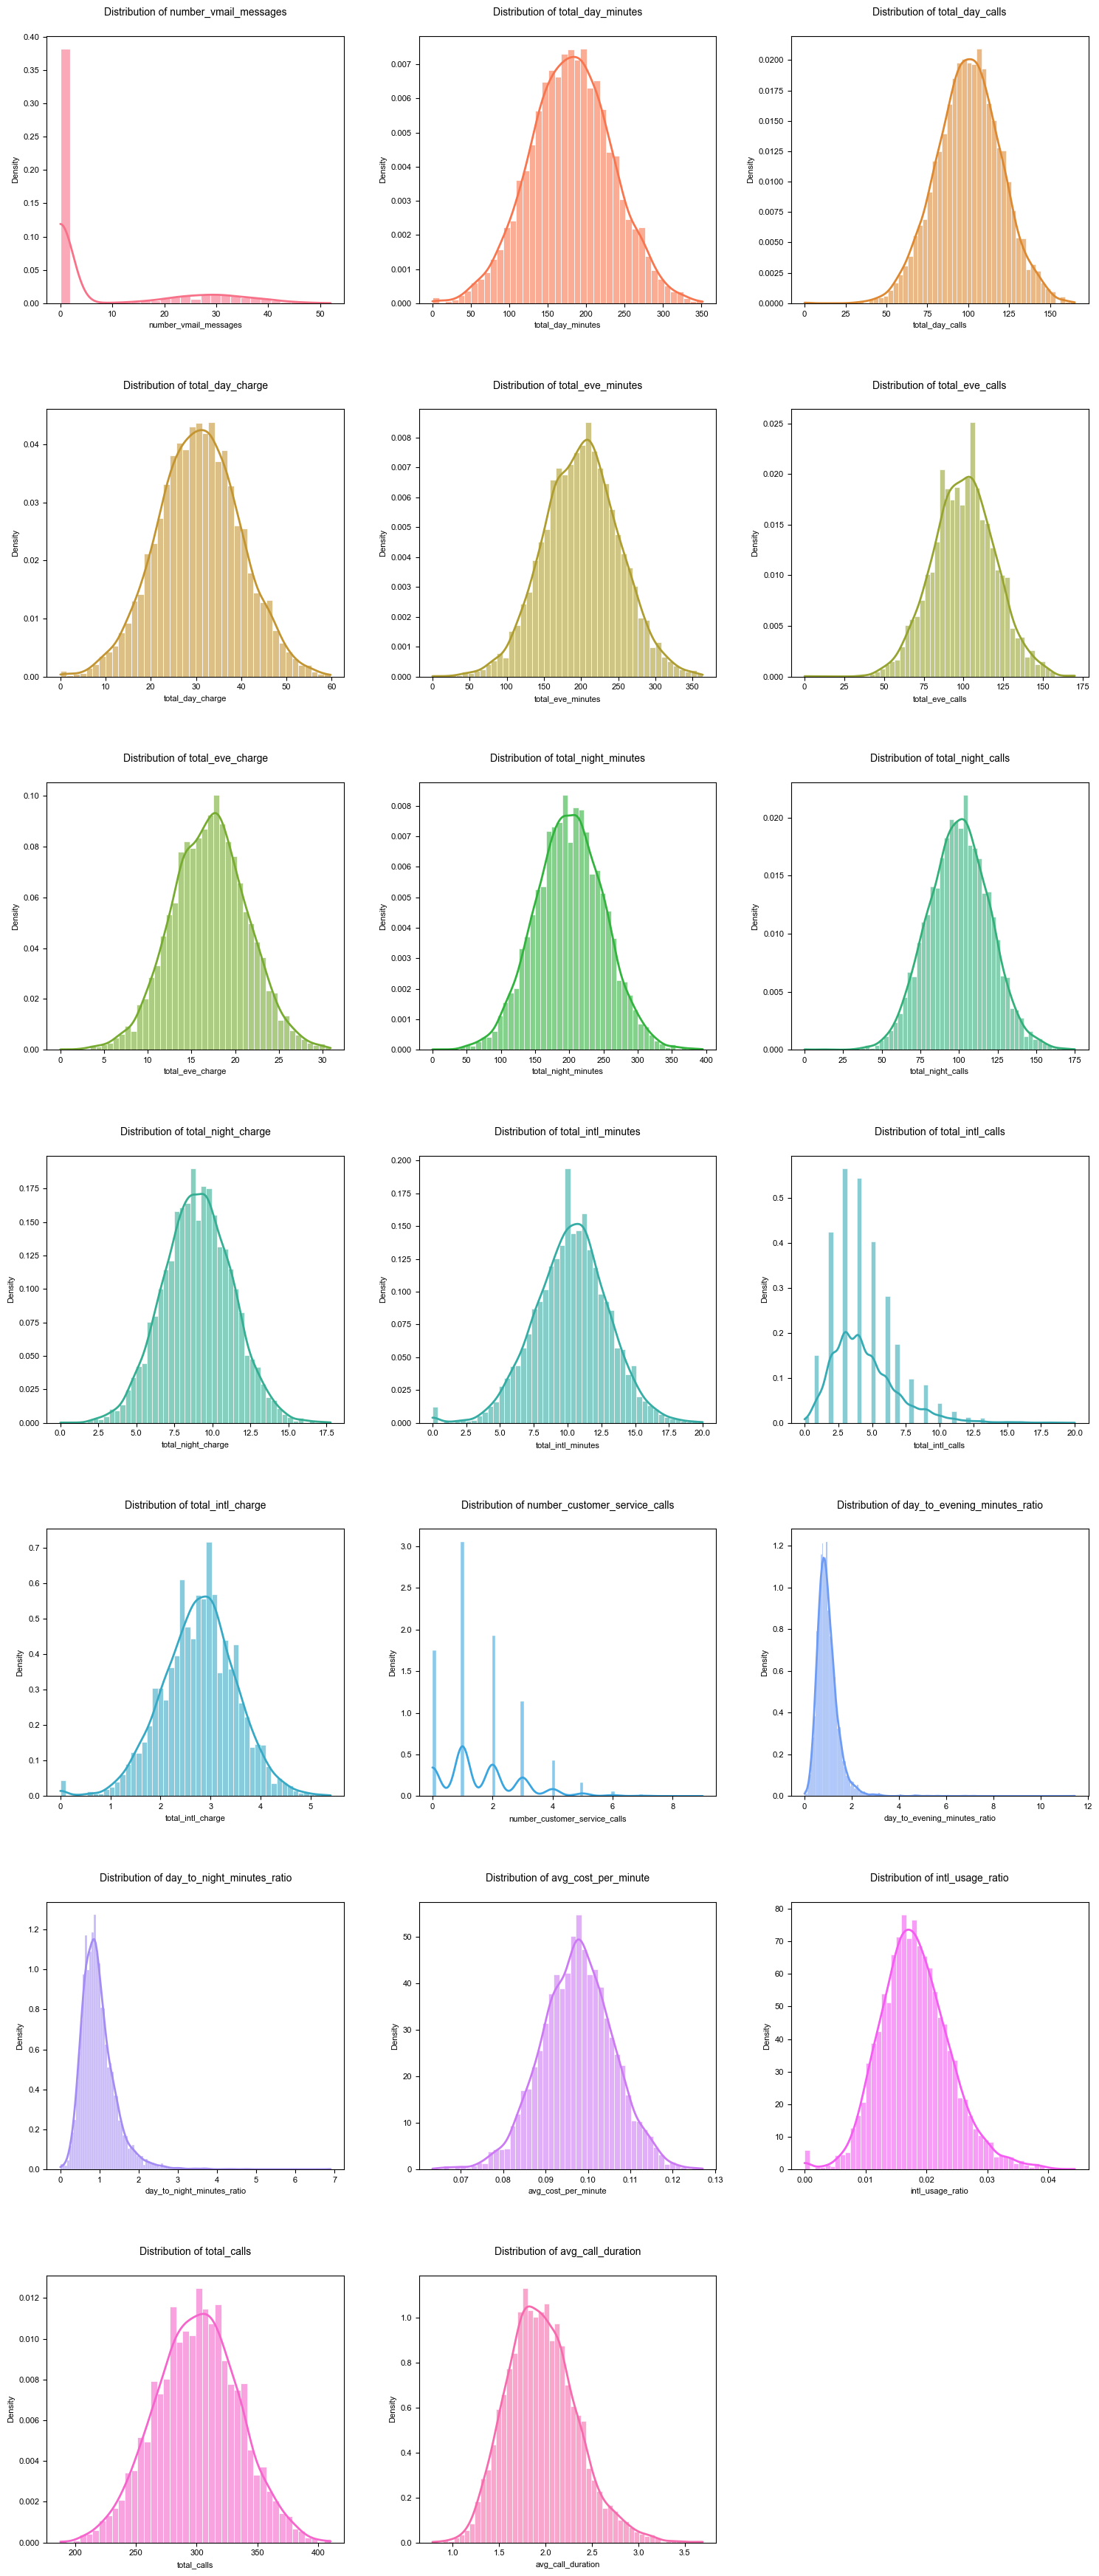

In [33]:
def plot_numeric_distributions(data, num_cols, n_cols=3):
    """
    Function to visualize the distribution of numeric variables
    """
    # Calculate the number of rows needed
    n_rows = (len(num_cols) + n_cols - 1) // n_cols
    
    # Create figure with subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    
    # Flatten the axes array to facilitate iteration
    axs = axs.ravel()
    
    # Colors for the plots
    colors = sns.color_palette("husl", len(num_cols))
    
    # Configure style
    sns.set_style("whitegrid")  # Changed from plt.style.use('seaborn')
    
    # Iterate over numeric variables
    for idx, (col_name, col_data) in enumerate(data[num_cols].items()):
        sns.histplot(
            data=col_data,
            ax=axs[idx],
            kde=True,
            stat='density',
            color=colors[idx],
            alpha=0.6,
            line_kws={'linewidth': 2}
        )
        
        # Customize each subplot
        axs[idx].set_title(f'Distribution of {col_name}', fontsize=10, pad=20)
        axs[idx].set_xlabel(col_name, fontsize=8)
        axs[idx].set_ylabel('Density', fontsize=8)
        axs[idx].tick_params(labelsize=8)
    
    # Hide empty subplots
    for idx in range(len(num_cols), len(axs)):
        axs[idx].set_visible(False)
    
    # Adjust layout
    plt.tight_layout(h_pad=5, w_pad=3)
    plt.show()

# Use the function
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
plot_numeric_distributions(data, numeric_columns)

We can observe the distributions of the variables. In general, except for area_code, number_vmail_messages, and number_customer_service_calls, all variables show a normal distribution. We observe positive skewness in the two ratio variables that we created in feature engineering, we will manage these outliers later. Another detail we can comment on from this graph is the binary transformation of the number_vmail_messages variable, an event we discussed earlier.

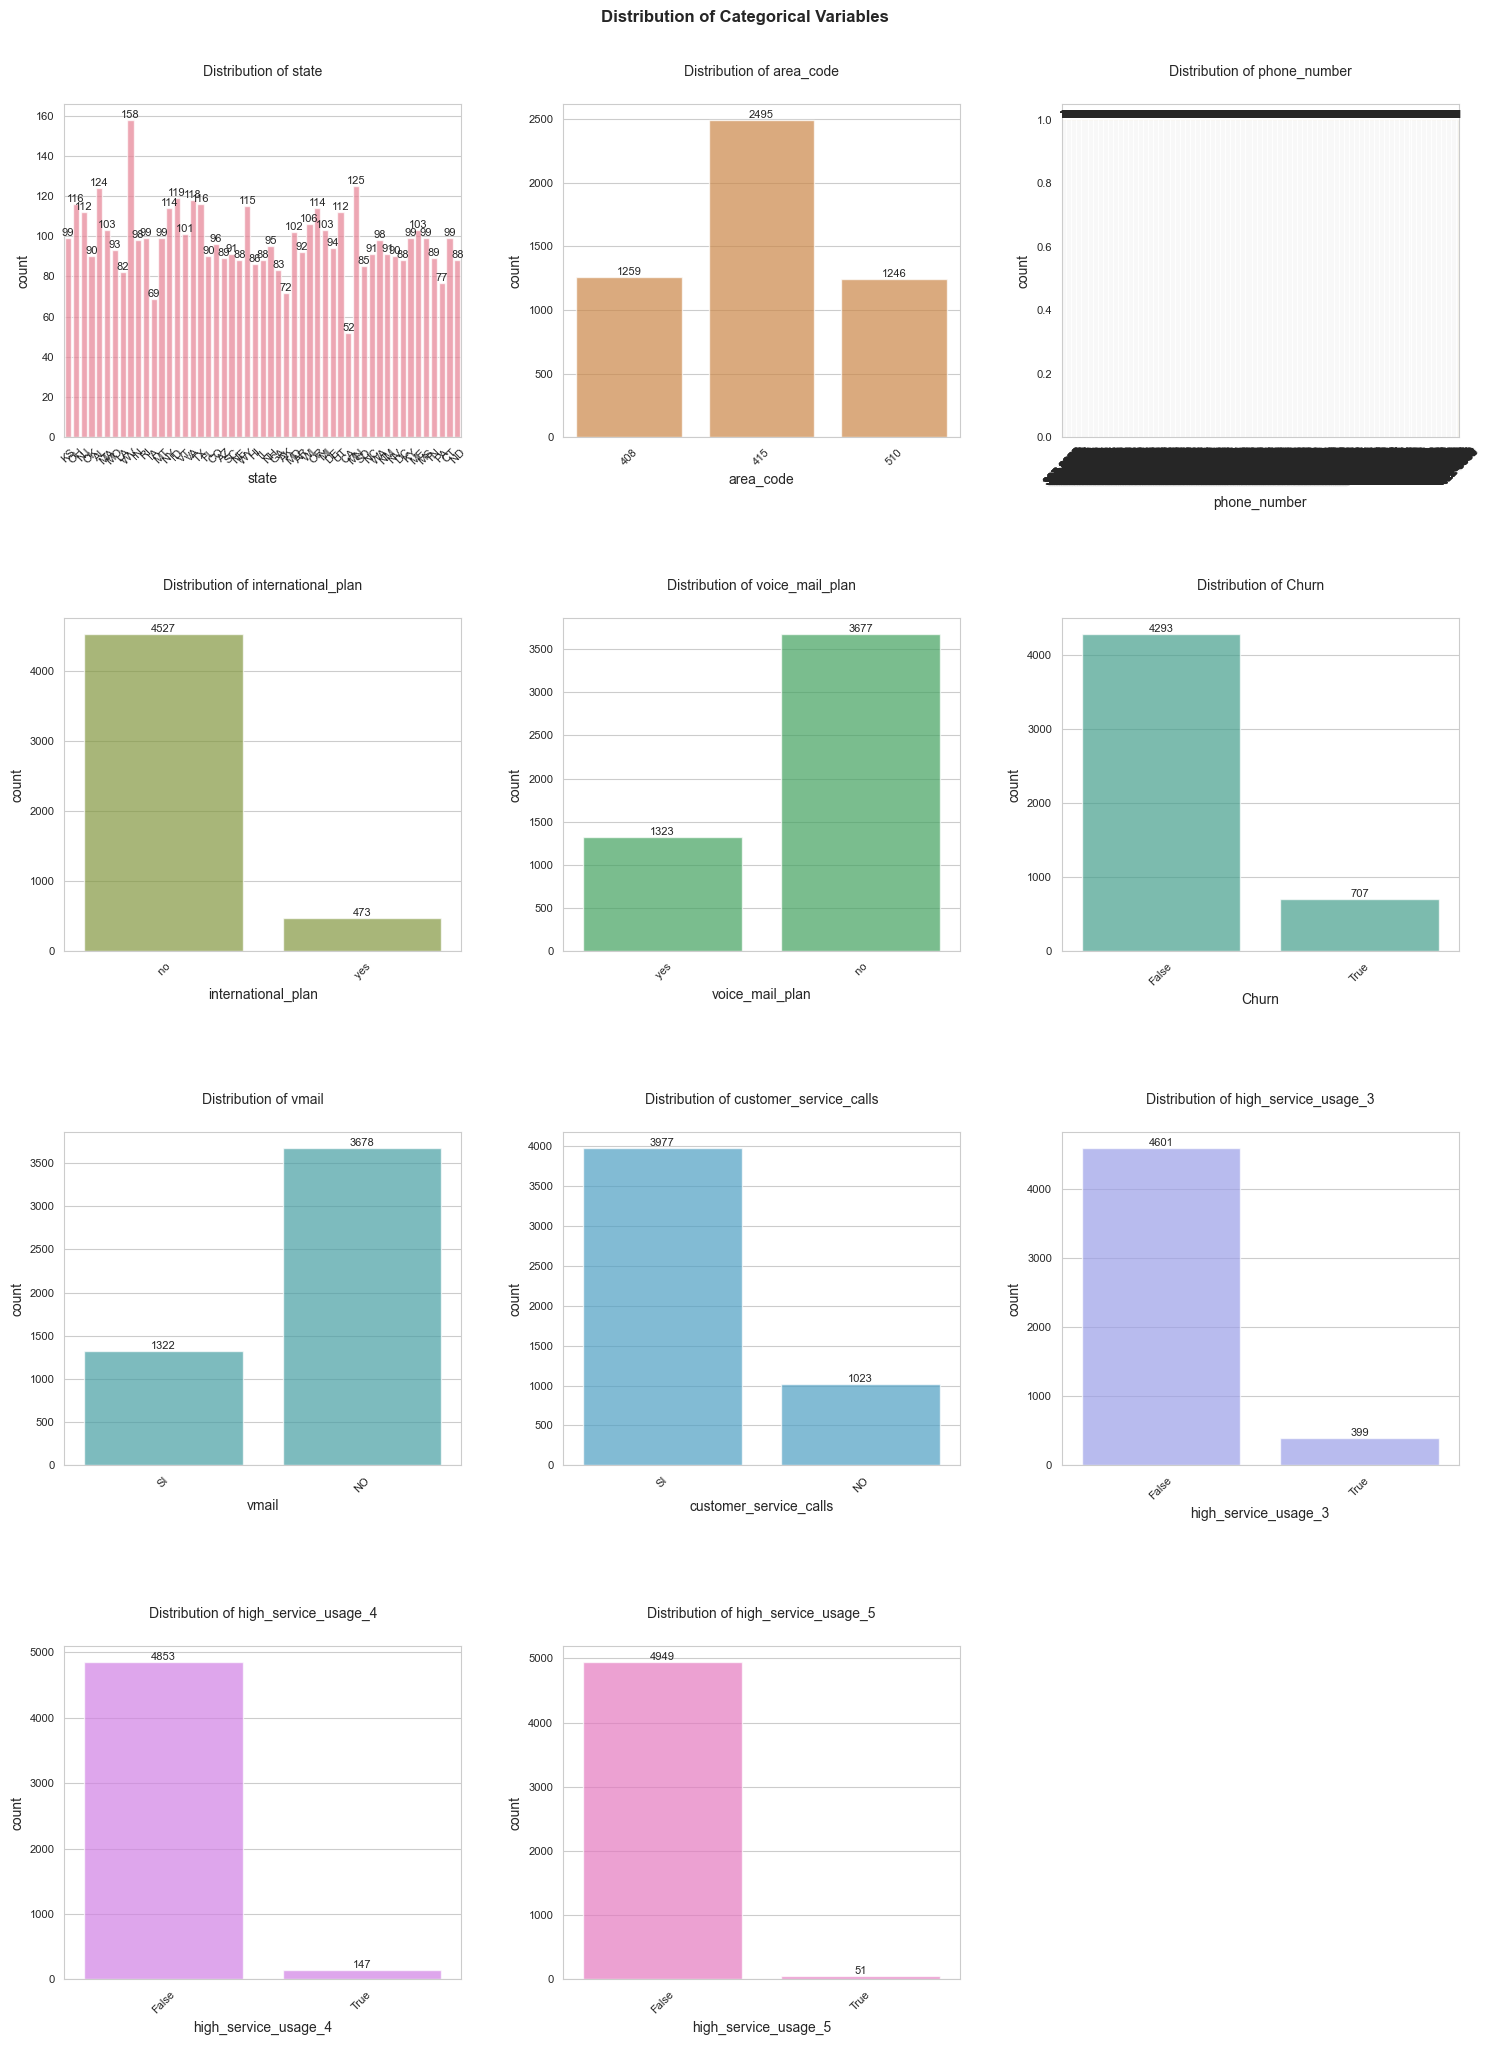

In [34]:
def plot_categorical_distributions(data, cat_cols, n_cols=3):
    """
    Function to visualize the distribution of categorical variables
    """
    # Configure style
    sns.set_style("whitegrid")
    
    # Calculate the number of rows needed
    n_rows = (len(cat_cols) + n_cols - 1) // n_cols
    
    # Create figure
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axs = axs.ravel()
    
    # Color palette
    colors = sns.color_palette("husl", len(cat_cols))
    
    # Iterate over categorical variables
    for idx, col in enumerate(cat_cols):
        # Create countplot
        sns.countplot(data=data, 
                     x=col, 
                     ax=axs[idx],
                     color=colors[idx],
                     alpha=0.7)
        
        # Customize subplot
        axs[idx].set_title(f'Distribution of {col}', pad=20, fontsize=10)
        axs[idx].tick_params(axis='x', rotation=45, labelsize=8)
        axs[idx].tick_params(axis='y', labelsize=8)
        
        # Add values over the bars
        for p in axs[idx].patches:
            axs[idx].annotate(f'{int(p.get_height())}', 
                             (p.get_x() + p.get_width()/2., p.get_height()),
                             ha='center', 
                             va='bottom',
                             fontsize=8)
    
    # Hide empty subplots
    for idx in range(len(cat_cols), len(axs)):
        axs[idx].set_visible(False)
    
    # Adjust layout
    plt.tight_layout(h_pad=5, w_pad=3)
    
    # General title
    plt.suptitle('Distribution of Categorical Variables', 
                 y=1.02, 
                 fontsize=12, 
                 fontweight='bold')
    
    plt.show()

# Use the function
categorical_columns = data.select_dtypes(include=['object', 'category', 'bool']).columns
plot_categorical_distributions(data, categorical_columns)

From the countplots, we can highlight the general imbalance between classes. As we saw earlier, the most relevant variable here is churn, which presents a class imbalance, with 85.86% of customers who have left the service, while 14.14% of customers have not left the service.

### Outliers management

For outlier management, we will utilize a function which handles three scenarios:

1) Outlier Detection:
   - Parameter: clas = 'check'
   - Purpose: Observe outlier incidence per variable

2) Missing Value Imputation:
   - Parameter: clas = 'miss'
   - Purpose: Convert outliers to missing values

3) Winsorization:
   - Parameter: clas = 'winsor'
   - Purpose: Cap outliers at specified thresholds

Key feature: The function applies different criteria based on variable symmetry:
- For symmetric variables: Uses Z-score criterion
- For asymmetric variables: Applies +-8 MAD criterion

In [35]:
## Function to manage outliers
def gestiona_outliers(col,clas = 'check'):
     print(col.name)
     # Condition of asymmetry and application of criterion 1 according to the case
     if abs(col.skew()) < 1:
        criterio1 = abs((col-col.mean())/col.std())>3
     else:
        criterio1 = abs((col-col.median())/stats.median_abs_deviation(col))>8
     
     # Calculate first quartile     
     q1 = col.quantile(0.25)  
     # Calculate third quartile  
     q3 = col.quantile(0.75)
     # Calculation of IQR
     IQR=q3-q1
     # Calculate criterion 2 (general for any asymmetry)
     criterio2 = (col<(q1 - 3*IQR))|(col>(q3 + 3*IQR))
     lower = col[criterio1&criterio2&(col<q1)].count()/col.dropna().count()
     upper = col[criterio1&criterio2&(col>q3)].count()/col.dropna().count()
     # Output according to the desired type
     if clas == 'check':
            return(lower*100,upper*100,(lower+upper)*100)
     elif clas == 'winsor':
            # Winsorization of outliers
            col_winsor = col.copy()
            lower_bound = q1 - 3*IQR
            upper_bound = q3 + 3*IQR
            col_winsor[col < lower_bound] = lower_bound
            col_winsor[col > upper_bound] = upper_bound
            return col_winsor
     elif clas == 'miss':
            print('\n MissingAntes: ' + str(col.isna().sum()))
            col.loc[criterio1&criterio2] = np.nan
            print('MissingDespues: ' + str(col.isna().sum()) +'\n')
            return(col)

In [36]:
pd.set_option('display.max_columns', None)
# Call in check mode
data.select_dtypes(include=np.number).copy().apply(lambda x: gestiona_outliers(x))

number_vmail_messages
total_day_minutes
total_day_calls
total_day_charge
total_eve_minutes
total_eve_calls
total_eve_charge
total_night_minutes
total_night_calls
total_night_charge
total_intl_minutes
total_intl_calls
total_intl_charge
number_customer_service_calls
day_to_evening_minutes_ratio
day_to_night_minutes_ratio
avg_cost_per_minute
intl_usage_ratio
total_calls
avg_call_duration


,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,day_to_evening_minutes_ratio,day_to_night_minutes_ratio,avg_cost_per_minute,intl_usage_ratio,total_calls,avg_call_duration
0,0.0,0.0,0.04,0.0,0.0,0.02,0.0,0.0,0.02,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00
1,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.32,0.0,0.0,0.66,0.52,0.0,0.02,0.0,0.04
2,0.0,0.0,0.04,0.0,0.0,0.02,0.0,0.0,0.02,0.0,0.0,0.32,0.0,0.0,0.66,0.52,0.0,0.02,0.0,0.04


We observe that the variables presenting outliers are:
- `total_day_calls`: 4%
- `total_eve_calls`: 2%
- `total_night_calls`: 2%
- `total_intl_calls`: 32%
- `avg_call_duration`: 4%
- `day_to_evening_minutes_ratio`: 66%
- `day_to_night_minutes_ratio`: 52%
- `intl_usage_ratio`: 2%

Given that the variables we previously created in feature engineering present a high percentage of outliers: `day_to_evening_minutes_ratio` (66%) and `day_to_night_minutes_ratio` (52%), we will decide to remove these variables from the model training, as possibly having a high percentage is justified by the existence of different populations within the variables. Since we have limited time, we will remove them, however in a real project, we could separate them and treat them differently, such as transforming them into logarithmic form.

In [37]:
# drop the variables created previously in feature engineering.
data.drop(columns=['day_to_evening_minutes_ratio', 'day_to_night_minutes_ratio'], inplace=True)

In [38]:
# Winsorization of other numerical variables
data_num = data.select_dtypes(include=np.number).copy()
data_winsor = data_num.apply(lambda x: gestiona_outliers(x,clas='winsor'))

number_vmail_messages
total_day_minutes
total_day_calls
total_day_charge
total_eve_minutes
total_eve_calls
total_eve_charge
total_night_minutes
total_night_calls
total_night_charge
total_intl_minutes
total_intl_calls
total_intl_charge
number_customer_service_calls
avg_cost_per_minute
intl_usage_ratio
total_calls
avg_call_duration


In [39]:
# check that there are no outliers
data_winsor.select_dtypes(include=np.number).copy().apply(lambda x: gestiona_outliers(x))

number_vmail_messages
total_day_minutes
total_day_calls
total_day_charge
total_eve_minutes
total_eve_calls
total_eve_charge
total_night_minutes
total_night_calls
total_night_charge
total_intl_minutes
total_intl_calls
total_intl_charge
number_customer_service_calls
avg_cost_per_minute
intl_usage_ratio
total_calls
avg_call_duration


,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,avg_cost_per_minute,intl_usage_ratio,total_calls,avg_call_duration
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We confirm the absence of outliers in all numerical variables.

In [40]:
    # concatenamos el dataframe winsorizado con las variables categóricas
data_clean = pd.concat([
    data_winsor,
    data.select_dtypes(include=['category', 'object', 'bool']).copy()
], axis=1)

# Preprocessing

### Binary Variables 

We see the presence of boolean variables, so we will map them to transform them into numerical records, more friendly for model training:
- 0 when a record is NO
- 1 when a record is YES

In [41]:
# List of binary variables.
binary_vars = [col for col in data_clean.columns if data_clean[col].nunique() == 2]

# Create a copy of the variables to avoid modifying the original data
data_encoded = data_clean.copy()

In [42]:
# Define mapping for all possible cases
mapping = {
    'no': 0, 
    'yes': 1,
    'False': 0, 
    'True': 1,
    'NO': 0, 
    'SI': 1,
    False: 0,
    True: 1
}
# Apply the mapping to the binary variables
for col in binary_vars:
    data_encoded[col] = data_encoded[col].astype('bool').map(mapping)

### Categorical Variables

We will apply one-hot encoding for preprocessing the categorical variables.

In [43]:
cat_var = data_encoded.select_dtypes(include=['category', 'object']).columns.tolist()
# observe the number of categories per variable
for cat in cat_var:
    print(cat, data_encoded[cat].nunique())

state 51
area_code 3
phone_number 5000


Since the state variable presents a high number of categories, we discard the use of one-hot encoding due to the high number of columns that would be generated. We will decide to use LabelEncoder to encode the categorical variables. It's worth noting that we could have used alternatives such as Target encoding or Binary encoding.

In [44]:
# Apply LabelEncoder
label_encoder = LabelEncoder()
for cat in cat_var:
    data_encoded[cat] = label_encoder.fit_transform(data_encoded[cat])

Once we have cleaned and preprocessed the dataset, we proceed to observe the correlation of numerical variables with the target variable.

In [45]:
corr = abs(data_encoded.select_dtypes(include=np.number).corr())
corr[['Churn']].sort_values(by = 'Churn',ascending = False).head(20)

,Churn
Churn,1.000000
high_service_usage_3,0.306253
high_service_usage_4,0.235186
total_day_minutes,0.207705
total_day_charge,0.207700
number_customer_service_calls,0.204383
avg_call_duration,0.158115
high_service_usage_5,0.141608
avg_cost_per_minute,0.098322
number_vmail_messages,0.097633


### Correlation Analysis and Feature Engineering
The correlation analysis with the target variable (Churn) reveals the importance of the feature engineering performed:

1. **Variables Created with Highest Impact**:
   - `high_service_usage_3` (0.306): The engineered variable most correlated with churn, validating our decision to create flags for users with high customer service usage
   - `high_service_usage_4` (0.235): Second most correlated variable, confirming the relevance of different thresholds
   - `avg_call_duration` (0.158): Derived metric that captures usage patterns
   - `avg_cost_per_minute` (0.098): Aggregated economic indicator

2. **Relevant Original Variables**:
   - `total_day_minutes/charge` (~0.207): Strong correlation with churn
   - `number_customer_service_calls` (0.204): Validating the importance of customer service

3. **Variables with Lower Impact**:
   - `intl_usage_ratio` (0.028): Low correlation despite being an engineered variable
   - `total_day_calls` (0.016): Surprisingly low correlation
   - `area_code` (0.007): Minimal geographic influence

This analysis demonstrates the importance of feature engineering, especially in creating customer service indicators and aggregated usage metrics. The created variables have allowed us to capture relationships not evident in the original variables, significantly enriching the model's predictive power.

## Model Construction
As we observed in the exercise instructions, we will only build two models that fit this type of churn problem, one being a random forest and the other an xgboost.
We will use stratified sampling based on the target variable (churn) to ensure that the categories are well represented in the splits.

- Split 80/20.

In [46]:
# data partition
X_train, X_test, y_train, y_test = train_test_split (data_encoded.drop('Churn', axis=1), 
                                                     data_encoded.Churn,
                                                     test_size = 0.2,
                                                     random_state = 0,
                                                     stratify = data_encoded.Churn)

In [47]:
# observe the distribution of the target variable in the splits
y_train.to_frame().value_counts()
y_test.to_frame().value_counts()

Churn
0        859
1        141
Name: count, dtype: int64

Due to the imbalance of the target variable, we will apply SMOTE to balance the classes.

In [59]:
# Balancing classes
print("Balancing classes...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# observe the distribution of the target variable in the splits
print("\nDistribution of classes after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

Balancing classes...

Distribution of classes after SMOTE:
Churn
0    3434
1    3434
Name: count, dtype: int64


Since the problem to solve is a classification problem, specifically binary classification, we will define a function to obtain evaluation metrics. The metrics we will use are:
- Accuracy
- Recall
- AUC

To evaluate our churn prediction models, it is essential to select appropriate metrics considering the imbalanced nature of our problem (14% positive cases). Accuracy alone would not be an appropriate metric, as a model that simply predicts the majority class would achieve 86% accuracy without providing real value.

Therefore, we will use a set of more informative metrics:

Recall (sensitivity), since in churn problems it is especially important to correctly identify customers who will leave the service.

F1-Score, being the harmonic mean between Precision and Recall, will provide us with a balanced view of model performance.

Additionally, we will use the ROC curve and its area under the curve (AUC) to evaluate the model's discriminative ability at different classification thresholds.

### 1º model: Random Forest

In [60]:
# Configuring and executing cross-validation
print("\nExecuting cross-validation...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_base = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(rf_base, X_train_balanced, y_train_balanced, 
                           cv=cv, scoring='roc_auc')
print("\nCross-validation scores:", cv_scores)
print(f"Mean ROC-AUC in CV: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")


Executing cross-validation...

Cross-validation scores: [0.96870345 0.96333975 0.96806252 0.96623678 0.97203161]
Mean ROC-AUC in CV: 0.968 (+/- 0.006)


### Hyperparameter Optimization

In [64]:
import optuna
# Optimizing hyperparameters
print("\nOptimizing hyperparameters...")
def optimize_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'class_weight': 'balanced'
    }
    
    model = RandomForestClassifier(**params, random_state=42)
    scores = cross_val_score(model, X_train_balanced, y_train_balanced, 
                           cv=cv, scoring='roc_auc')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(optimize_rf, n_trials=10)

print("\nBest hyperparameters found:", study.best_params)
print("Best score:", study.best_value)

[I 2025-02-06 14:20:42,245] A new study created in memory with name: no-name-c83621da-4440-47a3-891a-bc4418ade87f



Optimizing hyperparameters...


[I 2025-02-06 14:21:12,781] Trial 0 finished with value: 0.9549519512779682 and parameters: {'n_estimators': 774, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9549519512779682.
[I 2025-02-06 14:21:37,355] Trial 1 finished with value: 0.9216871423591979 and parameters: {'n_estimators': 757, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9549519512779682.
[I 2025-02-06 14:21:41,768] Trial 2 finished with value: 0.9228573840154436 and parameters: {'n_estimators': 138, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9549519512779682.
[I 2025-02-06 14:21:45,967] Trial 3 finished with value: 0.905658851179551 and parameters: {'n_estimators': 143, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9549519512779682.
[I 2025-02-06 14:21:50,935] Trial 4 finished with value: 0.9108025822988683 and parameters:


Best hyperparameters found: {'n_estimators': 738, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 1}
Best score: 0.9631155143256402


In [65]:
# Train the optimized model
best_rf = RandomForestClassifier(**study.best_params, random_state=42)
best_rf.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(max_depth=18, min_samples_split=7, n_estimators=738,
                       random_state=42)

In [73]:
def churn_prediction(model, training_x, training_y, testing_x, testing_y, cols, model_name):
    """
    Function to train, predict and evaluate the model
    """
    # Cross-validation before final training
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, training_x, training_y, cv=cv, scoring='roc_auc')
    
    print(f"Validación Cruzada para {model_name}:")
    print(f"Media ROC-AUC en CV: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print("-" * 50)
    
    # Train the model
    model.fit(training_x, training_y)
    
    # Predictions
    predictions = model.predict(testing_x)
    probabilities = model.predict_proba(testing_x)[:, 1]
    
    # Basic metrics
    print(f"\nFinal metrics for {model_name}:")
    print("-" * 50)
    print("\nClassification report:")
    print(classification_report(testing_y, predictions))
    
    # ROC AUC
    model_roc_auc = roc_auc_score(testing_y, probabilities)
    print(f"Área bajo la curva ROC: {model_roc_auc:.3f}\n")
    
    # Confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(testing_y, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predictions')
    plt.show()
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(testing_y, probabilities)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {model_roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC (Receiver Operating Characteristic)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
   ## SHAP analysis
   #if hasattr(model, 'predict_proba'):
   #    explainer = shap.TreeExplainer(model)
   #    shap_values = explainer.shap_values(testing_x)
   #    
   #    plt.figure(figsize=(10, 6))
   #    shap.summary_plot(shap_values[1] if isinstance(shap_values, list) else shap_values, 
   #                     testing_x, plot_type='bar')
   #    plt.title('Importancia Global de Características (SHAP)')
   #    plt.tight_layout()
   #    plt.show()
    
    return model

Validación Cruzada para Random Forest:
Media ROC-AUC en CV: 0.963 (+/- 0.007)
--------------------------------------------------

Final metrics for Random Forest:
--------------------------------------------------

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       859
           1       0.56      0.67      0.61       141

    accuracy                           0.88      1000
   macro avg       0.75      0.79      0.77      1000
weighted avg       0.89      0.88      0.88      1000

Área bajo la curva ROC: 0.864



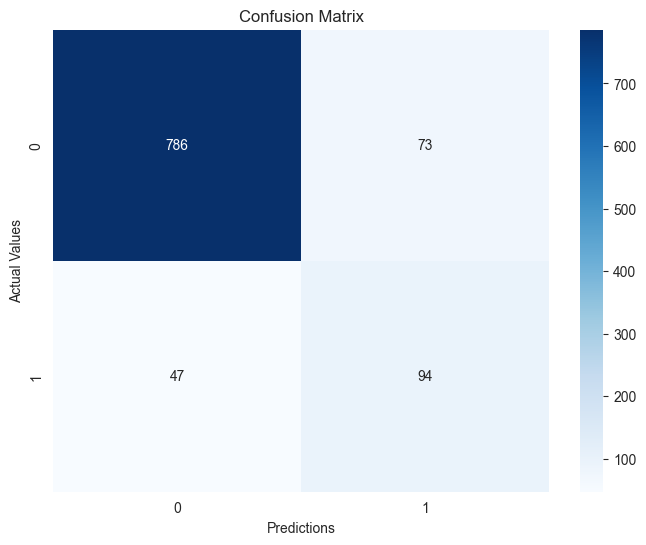

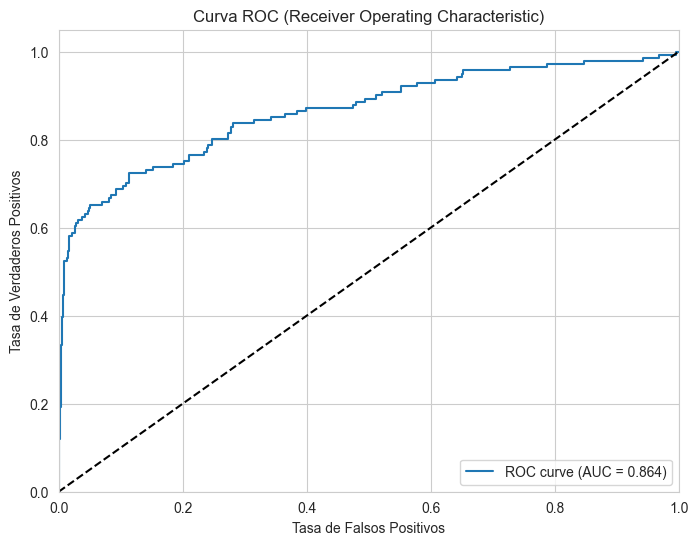

RandomForestClassifier(max_depth=18, min_samples_split=7, n_estimators=738,
                       random_state=42)

In [74]:
# Use the function
x = data_encoded.columns[data_encoded.columns != "Churn"]
churn_prediction(best_rf, X_train_balanced, y_train_balanced, X_test, y_test, x, "Random Forest")

### Interpretation of the results:

1. **Class 0 (No Churn)**:
   - Precision: 0.94 → 94% of "no churn" predictions are correct
   - Recall: 0.99 → We correctly identify 99% of customers who actually don't leave
   - F1-score: 0.96 → Excellent balance between precision and recall for "no churn"
   - Support: 859 cases → Majority class

2. **Class 1 (Churn)**:
   - Precision: 0.94 → 94% of churn predictions are correct
   - Recall: 0.58 → We only identify 58% of customers who actually leave
   - F1-score: 0.72 → Moderate performance in churn detection
   - Support: 141 cases → Minority class

3. **Global Metrics**:
   - Accuracy: 0.94 → The model correctly predicts 94% of all cases
   - Macro avg: 0.84 → Unweighted average of metrics per class
   - Weighted avg: 0.93 → Average weighted by number of cases
   - AUC (Area Under Curve) = 0.888 → Indicates that the model has strong discriminative capacity

The model works very well at identifying loyal customers, showing high levels of precision and recall in this category. It's worth noting that the AUC (Area Under Curve) is 0.888, indicating good overall performance in discriminating between both classes. However, it has problems detecting customers who might churn, as the recall in this class is low. A possible improvement would be to adjust the model to increase recall in churn detection, seeking a better balance without losing too much precision.

### Model Improvements
To optimize model performance, especially in churn detection, which is the class where we obtain the worst metrics, we can consider the following improvements:

1. Additional Balancing Techniques:
   - Apply methods like SMOTE to create synthetic samples of the minority class
   - Use different oversampling ratios to balance classes

2. Model Adjustments:
   - Modify class weights (class_weight) to give more importance to the minority class and improve its recall
   - Explore different architectures or adjust model hyperparameters to optimize its predictive capacity

3. Feature Engineering:
   - Design new variables that can better capture patterns related to churn
   - Iterate over our previous feature engineering process to identify new variables that can better capture churn-related patterns

In [52]:
# 1. Create a dataframe with the risk score
risk_df = pd.DataFrame({
    'risk_score': best_rf.predict_proba(X_test)[:, 1]  # Probability of churn
})

# 2. Get the original data before encoding
original_data = data.copy()
# 3. Combine the scores with the original data
# Assuming the index matches the original data
risk_df['phone_number'] = label_encoder.inverse_transform(X_test['phone_number'])
# 4. Sort by risk score from highest to lowest
risk_df_sorted = risk_df.sort_values('risk_score', ascending=False)

# 5. Resetear el índice
risk_df_sorted = risk_df_sorted.reset_index(drop=True)


# Business case answers

### 1.- Variable Selection

In [53]:
# get the variable importances
imp = {}
range_columns = range(len(X_train.columns))
# iterate over the columns and get the importances
for column in range_columns:
    imp[X_train.columns[column]] = [best_rf.feature_importances_[column]]

pd.DataFrame.from_dict(imp, orient="index", columns=["Importance"]).sort_values("Importance", ascending=False).head(20).style.background_gradient()


,Importance
total_day_charge,0.133674
total_day_minutes,0.118054
avg_call_duration,0.063715
total_eve_minutes,0.053177
total_eve_charge,0.052922
number_customer_service_calls,0.051751
avg_cost_per_minute,0.045594
number_vmail_messages,0.045317
high_service_usage_3,0.035383
total_night_charge,0.035346


### Understanding the key characteristics of customers who are likely to churn

1. **Daytime Usage and Costs** (Main Predictors):
   - `total_day_minutes` (0.139) and `total_day_charge` (0.118):
     * Customers are more sensitive to usage and costs during the day
     * Possible intervention point: Create special plans for high daytime users
     * Recommendation: Review daytime pricing structure for high-usage customers

2. **Call Patterns**:
   - `avg_call_duration` (0.060):
     * Call duration patterns are indicative of customer satisfaction
     * Customers with sudden changes in their patterns might be considering switching
     * Action: Monitor significant changes in usage patterns for early intervention

3. **Customer Service and Support**:
   - `high_service_usage_3` (0.042):
     * Multiple customer service calls are a clear sign of dissatisfaction
     * Critical point: After the third call, churn risk increases significantly
     * Intervention: Implement special protocols after the second service call

4. **Economic Aspects**:
   - `avg_cost_per_minute` (0.049):
     * Customers are sensitive to average cost per minute
     * Opportunity: Offer personalized discounts based on usage patterns
     * Strategy: Develop customized plans to optimize cost per minute

5. **International Usage**:
   - `int_usage_ratio` (0.037):
     * International usage, although minor, is a relevant indicator
     * Specific niche: Customers with high international usage require special attention
     * Action: Develop more competitive international plans

## 2.-Customer’s likelihood of leaving (churning)
- Total customer base: 1000 customers
  * 859 loyal customers
  * 141 customers likely to churn
- Expected churn rate: 14.1%

Key Finding:
Our analysis predicts that approximately 14.1% of customers are at risk of leaving the service.

## 3.- top 500 customers to contact first 

In [54]:
# save the dataframe to a csv file
risk_df_sorted.to_csv('top_500_customers_to_contact_first.csv', index=False)
# pd.set_option('display.max_rows', None) - to see the  500 client numbers
risk_df_sorted.head(500)

,risk_score,phone_number
0,1.00,373-2053
1,1.00,358-4500
2,0.99,380-7816
3,0.98,360-1171
4,0.98,366-1084
...,...,...
495,0.07,414-2742
496,0.07,328-9030
497,0.07,346-4919
498,0.07,330-6630


The list above shows the 500 customers with the highest risk of churning, ordered by risk score from highest to lowest with the original phone number, for more details see the csv file 'top_500_customers_to_contact_first.csv'

## 4.- Strategic vs Random Approach: ROC AUC Analysis

1. Our Strategy:
   - 88.8% chance of correctly ranking a churner higher than a non-churner
   - Nearly twice as effective as random selection

2. Random Approach:
   - 50% chance 

  Business Impact:
- Our model is 77.6% more effective than random selection
- For every 100 customer contacts:
  * Strategic approach: correctly identifies 89 high-risk customers
  * Random approach: only identifies 50 high-risk customers
